In [1]:
from sklearn.mixture import GaussianMixture
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd 'drive/MyDrive/GitHub/master-thesis'

/content/drive/MyDrive/GitHub/master-thesis


In [5]:
from clustering.utils import *

In [ ]:
#%cd ..

# Import Data

In [6]:
df, answers, info_dict = get_cluster_input_data(pca_data=False)
df.head()

,gender,postnr,region,Q1_2_covid_is_threat,Q2_1_easy_to_follow_advice,Q2_2_can_follow_advice_if_wanted,Q2_3_if_follow_advice_safe,Q2_4_if_follow_advice_others_safe,Q2_5_follow_advice_relationships_impared,Q2_6_follow_advice_life_degraded,...,Q14_ocupation_employee_private,Q14_ocupation_unemployed,Q14_ocupation_employee_public,Q14_ocupation_self_employed,Q14_ocupation_student,Q14_ocupation_other,Q15_economic_spectrum,Q15_social_spectrum,Q16_economic_spectrum,Q16_social_spectrum
0,Man,2830,Capital,4.796778,5.0,7.0,4.0,7.0,4.0,5.0,...,0,0,1,0,0,0,2.0,4.0,4.0,2.0
1,Woman,4654,Zealand,7.000000,7.0,7.0,5.0,7.0,6.0,5.0,...,0,0,1,0,0,0,2.0,4.0,2.0,4.0
2,Woman,7451,Central,7.000000,7.0,7.0,7.0,7.0,4.0,3.0,...,0,0,1,0,0,0,NaN,NaN,NaN,NaN
3,Man,4700,Zealand,6.000000,1.0,7.0,2.0,1.0,7.0,4.0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
4,Man,4000,Zealand,5.000000,1.0,1.0,2.0,1.0,2.0,2.0,...,0,0,0,0,0,1,2.0,4.0,NaN,NaN


In [7]:
info_dict

{'cluster_input_cols': ['Q1_2_covid_is_threat',
  'Q2_1_easy_to_follow_advice',
  'Q2_2_can_follow_advice_if_wanted',
  'Q2_3_if_follow_advice_safe',
  'Q2_4_if_follow_advice_others_safe',
  'Q2_5_follow_advice_relationships_impared',
  'Q2_6_follow_advice_life_degraded',
  'Q3_1_aware_hand_hygiene',
  'Q3_2_avoid_contact',
  'Q3_3_ensure_frequent_cleaning',
  'Q3_4_avoid_risk_groups',
  'Q3_5_keep_distance',
  'Q3_6_avoid_crowds',
  'Q3_7_minimize_activities_w_contact',
  'Q5_4_yourself_kept_distance',
  'Q5_5_feel_urge_scold',
  'Q6_2_advices_important',
  'Q6_3_others_can_avoid_spreading',
  'Q6_5_ownership_of_advice',
  'Q6_6_clear_information_on_advice_reason',
  'Q6_7_advice_limits_daily_activities',
  'Q6_9_trust_political_strategy',
  'Ny1_nr_times_wearing_masks_last_week'],
 'data_path': 'data/preprocessing/220216_preprocessed_data_missing_data.csv',
 'pca_data': False,
 'scaler_type': 'MinMaxScaler()'}

In [8]:
answers_sampled = pd.DataFrame(answers).sample(10000).to_numpy()

# GM clustering

## Probabilistic Approach to determine number of clusters

### Prior Distribution

In [9]:
from scipy.stats import norm
mean = 2
std = 3
prior_dist = norm(loc=mean, scale=std)

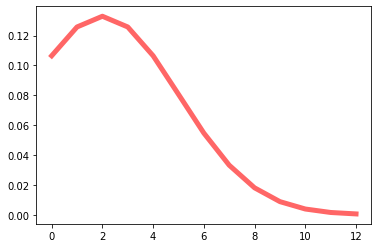

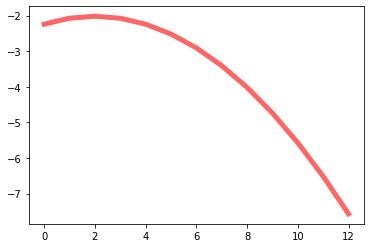

In [18]:
x = np.arange(13)
plt.plot(x, prior_dist.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')
plt.show()
plt.plot(x, prior_dist.logpdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')
plt.show()

## Calculate and Plot

In [11]:
# Set up a range of cluster numbers to try
n_range = range(1,15)
list_log_prob_data_given_model = []
list_log_prob_model = []
list_score = []

# Loop through the range and fit a model
for n in tqdm(n_range):
    # init & fit gmm
    gm = GaussianMixture(n_components=n, 
                         random_state=123, 
                         n_init=6)
    gm.fit(answers_sampled)
    
    # Calculate Log Probabilities
    log_prob_data_given_model = -gm.bic(answers_sampled) # Computes the per-sample average log-likelihood of the given data X - can be approximated by using BIC Score
    log_prob_model = prior_dist.logpdf(n)

    # Append values to list
    list_log_prob_data_given_model.append(log_prob_data_given_model)
    list_log_prob_model.append(log_prob_model)

100%|██████████| 14/14 [02:52<00:00, 12.34s/it]


In [37]:
def min_max_scaler(input_list):
  input_array = np.array(input_list)
  input_array_scaled = (input_array - input_array.min()) / (input_array.max() - input_array.min())
  return input_array_scaled

In [38]:
log_prob_data_given_model_scaled = min_max_scaler(list_log_prob_data_given_model) * (-1) # multiply with -1 so that we get a maximization problem
log_prob_model_scaled = min_max_scaler(list_log_prob_model)
score = log_prob_data_given_model_scaled + log_prob_model_scaled
score

array([-0.00694444,  0.25747512,  0.37411652,  0.4473364 ,  0.58622586,
        0.65732144,  0.60625519,  0.5615533 ,  0.49739332,  0.45963685,
        0.35017922,  0.2421313 ,  0.15972222, -0.03779811])

Text(0.5, 1.0, 'Probabilistic Evaluation')

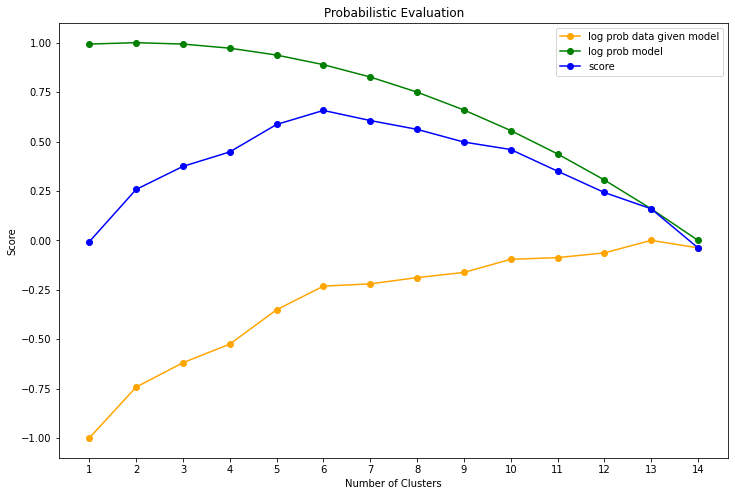

In [39]:
# Plot Probabilistic Evaluation
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(n_range, log_prob_data_given_model_scaled, '-o', color='orange', label='log prob data given model')
ax.plot(n_range, log_prob_model_scaled, '-o', color='green', label='log prob model')
ax.plot(n_range, score, '-o', color='blue', label='score')
ax.set(xlabel='Number of Clusters', ylabel='Score')
ax.set_xticks(n_range)
ax.legend()
ax.set_title('Probabilistic Evaluation')

In [42]:
n_clusters = n_range[np.argmax(score)]
n_clusters

6

## GM fit with determined number of cluster

In [ ]:
n_clusters = 3
gm = GaussianMixture(n_components=n_clusters, 
                         random_state=123, 
                         n_init=6)
gm.fit(answers)

GaussianMixture(n_components=3, n_init=6, random_state=123)

In [ ]:
df['group'] = gm.predict(answers)
df['group_prob'] = pd.DataFrame(gm.predict_proba(answers)).max(axis=1)
df.head()

,gender,postnr,region,Q1_2_covid_is_threat,Q2_1_easy_to_follow_advice,Q2_2_can_follow_advice_if_wanted,Q2_3_if_follow_advice_safe,Q2_4_if_follow_advice_others_safe,Q2_5_follow_advice_relationships_impared,Q2_6_follow_advice_life_degraded,...,Q14_ocupation_employee_public,Q14_ocupation_self_employed,Q14_ocupation_student,Q14_ocupation_other,Q15_economic_spectrum,Q15_social_spectrum,Q16_economic_spectrum,Q16_social_spectrum,group,group_prob
0,Man,2830,Capital,4.796778,5.0,7.0,4.0,7.0,4.0,5.0,...,1,0,0,0,2.0,4.0,4.0,2.0,0,0.997792
1,Woman,4654,Zealand,7.000000,7.0,7.0,5.0,7.0,6.0,5.0,...,1,0,0,0,2.0,4.0,2.0,4.0,1,0.999983
2,Woman,7451,Central,7.000000,7.0,7.0,7.0,7.0,4.0,3.0,...,1,0,0,0,NaN,NaN,NaN,NaN,0,0.994414
3,Man,4700,Zealand,6.000000,1.0,7.0,2.0,1.0,7.0,4.0,...,0,0,0,0,NaN,NaN,NaN,NaN,1,0.992695
4,Man,4000,Zealand,5.000000,1.0,1.0,2.0,1.0,2.0,2.0,...,0,0,0,1,2.0,4.0,NaN,NaN,2,1.000000


## Save for general clustering evaluation

In [ ]:
df.to_csv('data/clustering/220323_gmm_clustered_3cluster.csv', index=False)

# Specific Clustering Method Analysis

In [ ]:
gm.weights_

array([0.28843901, 0.44322344, 0.26833755])

In [ ]:
df['group'].value_counts(dropna=False)

1    54541
0    36294
2    31994
Name: group, dtype: int64

## Group Probability

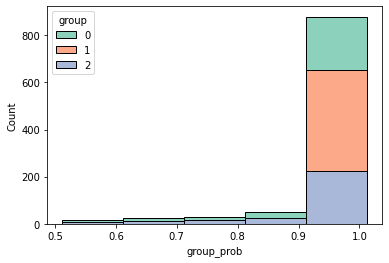

In [ ]:
df_sample = df.sample(1000)
sns.histplot(data=df_sample, multiple='stack', x="group_prob", hue="group", log_scale=(False, False), binwidth=0.1, palette='Set2')
plt.show()

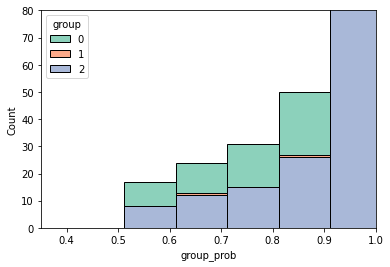

In [ ]:
fig, ax = plt.subplots()
sns.histplot(data=df_sample, ax=ax, multiple='stack', x="group_prob", hue="group", log_scale=(False, False), binwidth=0.1, palette='Set2')
ax.set_xlim(0.35, 1)
ax.set_ylim(0,80)
plt.show()

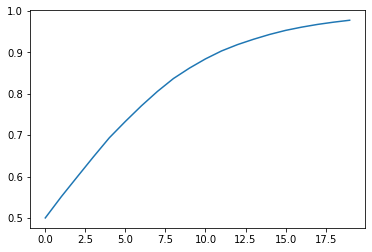

In [ ]:
prob_list = []
for i in np.arange(0, 0.2, 0.01):
  prob = df['group_prob'].quantile(i)
  prob_list.append(prob)

plt.plot(prob_list)
plt.show()